In [ ]:
**Генерация признаков**
Feature Engineering — это процесс преобразования необработанных данных в признаки, которые лучше описывают базовую проблему для моделей машинного обучения, что позволяет улучшить их предсказательную способность. Данная техника включает в себя несколько подходов: создание новых признаков из существующих, преобразование числовых признаков, логарифмическое преобразование, обработка текстовых признаков.

**Формулировка задачи** 
С использованием датасета Титаника созданим и трансформируем признаки. После создания признаков,  обучим на них логистическую регрессию, чтобы продемонстрировать, как Feature Engineering улучшает производительность.

In [25]:
#Установим необходимые библиотеки

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler # модули для предобработки данных 
from sklearn.impute import SimpleImputer # для пропущенных значений
from sklearn.model_selection import train_test_split, cross_val_score, KFold # разделение данных на обучающую и тестовую выборку, кросс-валидация 
from sklearn.linear_model import LogisticRegression # Для обучения модели
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # оценка качества модели
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [35]:
# Загрузка датасета Титаник 
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

print("Исходный датафрейм:")
print(df.head())
print("Информация об исходном датафрейме")
df.info()
print("\nКоличество пропущенных значений в исходном датафрейме:")
print(df.isnull().sum())

Исходный датафрейм:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500

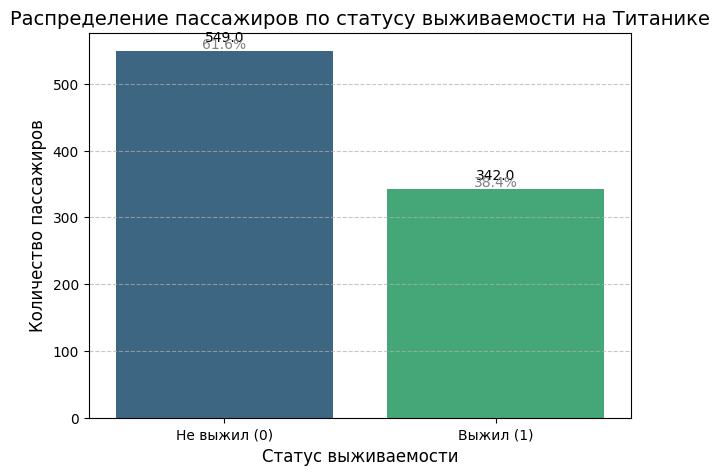

In [54]:
# Распределение классов в 'Survived'
plt.figure(figsize=(7, 5)) 

ax = sns.countplot(x='Survived', data=df, hue='Survived', palette='viridis', legend=False)

# Добавляем заголовок и метки осей
plt.title('Распределение пассажиров по статусу выживаемости на Титанике', fontsize=14)
plt.xlabel('Статус выживаемости', fontsize=12)
plt.ylabel('Количество пассажиров', fontsize=12)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Не выжил (0)', 'Выжил (1)'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

total = len(df['Survived'])
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', xytext=(0, 0), textcoords='offset points', fontsize=10, color='gray')


plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()


In [36]:
# Feature Engineering и предобработка 

# Извлечение Title из Name
print("Feature Engineering: Извлечение и обработка Title")
df['Title'] = df['Name'].apply(lambda x: re.search(r' ([A-Za-z]+)\.', x).group(1) if re.search(r' ([A-Za-z]+)\.', x) else '')
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'Mlle', 'Ms', 'Mme'], \
    ['Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Rare', 'Miss', 'Miss', 'Mrs'])

print("Уникальные титулы после обработки: ", df['Title'].value_counts().index.tolist())

Feature Engineering: Извлечение и обработка Title
Уникальные титулы после обработки:  ['Mr', 'Miss', 'Mrs', 'Master', 'Rare']


In [37]:
# Обработка пропущенных значений (попробуем разными способами)
imputer_age = SimpleImputer(strategy="mean")
df['Age'] = imputer_age.fit_transform(df[['Age']])

imputer_embarked = SimpleImputer(strategy="most_frequent")
df['Embarked'] = imputer_embarked.fit_transform(df[['Embarked']]).ravel()

imputer_fare = SimpleImputer(strategy="median")
df['Fare'] = imputer_fare.fit_transform(df[['Fare']])

df.info()
print("\nКоличество пропущенных значений в обработанном датафрейме:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB

Количество пропущенных значений в обработанном датафрейме:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch    

In [38]:
# Создание новых признаков и преобразование существующих
df['HasCabin'] = df['Cabin'].notna().astype(int) # Признак наличия каюты
df.drop(columns=['Cabin'], inplace=True)

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # Признак размера семьи (включая самого пассажира)
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

bins = [0, 12, 18, 60, np.inf] # Определение границ для возрастных групп
labels = ['Child', 'Teenager', 'Adult', 'Senior'] # Создание меток для возрастных групп
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

df['FarePerPerson'] = df['Fare'] / df['FamilySize']
# Заполнение бесконечных значений (если FamilySize был 0, что невозможно, но для надежности)
df['FarePerPerson'] = df['FarePerPerson'].replace(np.inf, df['Fare'].max())

df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,HasCabin,FamilySize,IsAlone,AgeGroup,FarePerPerson
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,0,2,0,Adult,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,2,0,Adult,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1,Adult,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1,2,0,Adult,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,0,1,1,Adult,8.05000


In [39]:
# Теперь удалим ненужные столбцы, которые не будут использоваться в модели
columns_to_drop_final = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch']
df.drop(columns=columns_to_drop_final, inplace=True)


print("\Датафрейм после Feature Engineering и предобработки:")
print(df.head())

\Датафрейм после Feature Engineering и предобработки:
   Survived  Pclass     Sex   Age     Fare Embarked Title  HasCabin  \
0         0       3    male  22.0   7.2500        S    Mr         0   
1         1       1  female  38.0  71.2833        C   Mrs         1   
2         1       3  female  26.0   7.9250        S  Miss         0   
3         1       1  female  35.0  53.1000        S   Mrs         1   
4         0       3    male  35.0   8.0500        S    Mr         0   

   FamilySize  IsAlone AgeGroup  FarePerPerson  
0           2        0    Adult        3.62500  
1           2        0    Adult       35.64165  
2           1        1    Adult        7.92500  
3           2        0    Adult       26.55000  
4           1        1    Adult        8.05000  


In [40]:
#  Кодирование категориальных данных 

le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])

# One-Hot Encoding для всех остальных категориальных признаков
df = pd.get_dummies(df, columns=['Embarked', 'Pclass', 'Title', 'AgeGroup'], prefix=['Embarked', 'Pclass', 'Title', 'AgeGroup'], dtype=int)

In [ ]:
print("Датафрейм после One-Hot Encoding (первые 5 строк):")
df.head(30) # посмотрим побольше строк, чтобы увидеть результат заполнения пропущенных значений в Age с помощью среднего значения

Датафрейм после One-Hot Encoding (первые 5 строк):


,Survived,Sex,Age,Fare,HasCabin,FamilySize,IsAlone,FarePerPerson,Embarked_C,Embarked_Q,...,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Adult,AgeGroup_Senior
0,0,1,22.000000,7.2500,0,2,0,3.625000,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,38.000000,71.2833,1,2,0,35.641650,1,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0,26.000000,7.9250,0,1,1,7.925000,0,0,...,1,0,1,0,0,0,0,0,1,0
3,1,0,35.000000,53.1000,1,2,0,26.550000,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,1,35.000000,8.0500,0,1,1,8.050000,0,0,...,1,0,0,1,0,0,0,0,1,0
5,0,1,29.699118,8.4583,0,1,1,8.458300,0,1,...,1,0,0,1,0,0,0,0,1,0
6,0,1,54.000000,51.8625,1,1,1,51.862500,0,0,...,0,0,0,1,0,0,0,0,1,0
7,0,1,2.000000,21.0750,0,5,0,4.215000,0,0,...,1,1,0,0,0,0,1,0,0,0
8,1,0,27.000000,11.1333,0,3,0,3.711100,0,0,...,1,0,0,0,1,0,0,0,1,0
9,1,0,14.000000,30.0708,0,2,0,15.035400,1,0,...,0,0,0,0,1,0,0,1,0,0


In [44]:
# Разделение данных на признаки (X) и целевую переменную (y) ---
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Масштабирование данных (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# Обучение модели (Логистическая Регрессия)
model_logreg = LogisticRegression(random_state=42, solver='liblinear') # liblinear хорошо работает с небольшими данными
model_logreg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [49]:
# Оценка модели 
print("Оценка модели Логистической Регрессии")
y_pred_logreg = model_logreg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_logreg)
class_report = classification_report(y_test, y_pred_logreg)

print(f"Точность модели: {accuracy:.4f}")
print("\nОтчет по классификации:\n", class_report)

Оценка модели Логистической Регрессии
Точность модели: 0.8324

Отчет по классификации:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



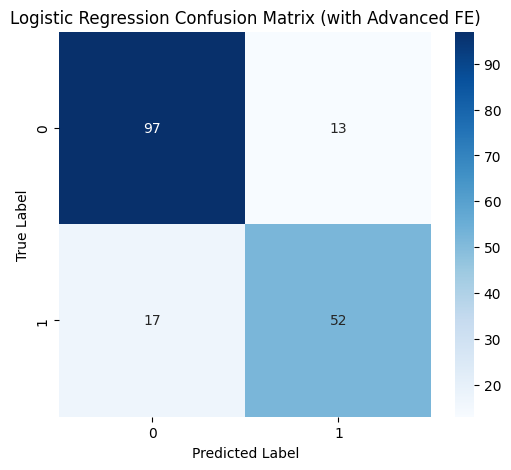

In [50]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix (with Advanced FE)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Некоторые итоги: Feature Engineering достоточно энергозатратный и долгий процесс для улучшения показатлей модели (более того, показатели не сильно то и улучшились). Данный процесс неатоматизирован, разработчику нужно самостоятельно придумать фичи. 
Можно улучшить данный процесс с помощью Automated Feature Engineering - AFE.

In [ ]:
import featuretools
print(featuretools.__version__)

ModuleNotFoundError: No module named 'pkg_resources'

: 